Device: cuda
Training plain network ...


100%|██████████| 170M/170M [00:03<00:00, 43.7MB/s]


Epoch 1/60 | Train loss 1.8253 acc 30.11% | Val loss 1.8253 acc 34.70% | time 24.0s
Epoch 2/60 | Train loss 1.5576 acc 41.28% | Val loss 1.5553 acc 44.17% | time 22.9s
Epoch 3/60 | Train loss 1.3279 acc 51.46% | Val loss 1.5739 acc 48.47% | time 23.3s
Epoch 4/60 | Train loss 1.1705 acc 57.75% | Val loss 1.2858 acc 56.16% | time 23.3s
Epoch 5/60 | Train loss 1.0563 acc 62.03% | Val loss 1.4145 acc 57.02% | time 23.3s
Epoch 6/60 | Train loss 0.9615 acc 65.86% | Val loss 1.0180 acc 63.32% | time 23.5s
Epoch 7/60 | Train loss 0.8766 acc 69.30% | Val loss 0.9099 acc 69.00% | time 22.8s
Epoch 8/60 | Train loss 0.8143 acc 71.40% | Val loss 0.9147 acc 69.67% | time 23.5s
Epoch 9/60 | Train loss 0.7618 acc 73.56% | Val loss 0.8698 acc 70.70% | time 23.0s
Epoch 10/60 | Train loss 0.7220 acc 75.14% | Val loss 0.8428 acc 71.05% | time 23.0s
Epoch 11/60 | Train loss 0.6877 acc 76.22% | Val loss 0.9763 acc 69.51% | time 23.1s
Epoch 12/60 | Train loss 0.6641 acc 77.03% | Val loss 0.7259 acc 75.90% | 

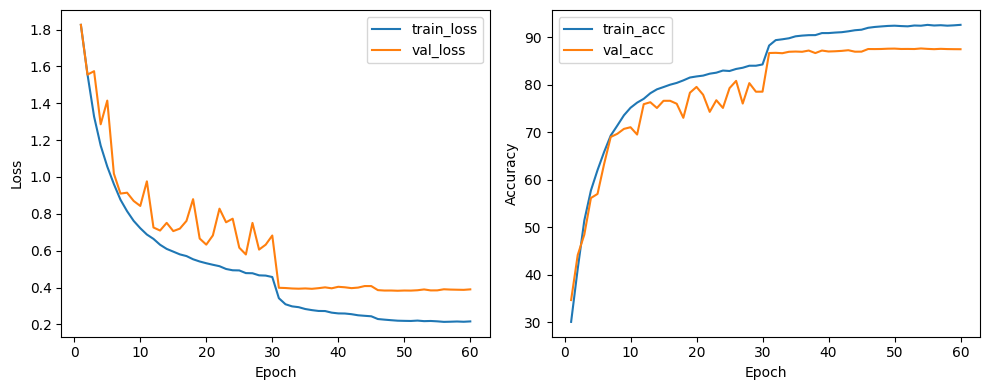

Training residual network ...
Epoch 1/60 | Train loss 1.9217 acc 27.88% | Val loss 1.7214 acc 36.92% | time 30.0s
Epoch 2/60 | Train loss 1.4735 acc 45.69% | Val loss 1.3649 acc 50.32% | time 30.0s
Epoch 3/60 | Train loss 1.1882 acc 56.80% | Val loss 1.1324 acc 60.34% | time 30.8s
Epoch 4/60 | Train loss 0.9628 acc 65.53% | Val loss 0.9348 acc 67.59% | time 30.2s
Epoch 5/60 | Train loss 0.8154 acc 71.16% | Val loss 0.9281 acc 68.23% | time 31.4s
Epoch 6/60 | Train loss 0.7057 acc 75.42% | Val loss 0.7059 acc 76.18% | time 29.8s
Epoch 7/60 | Train loss 0.6275 acc 78.29% | Val loss 0.7657 acc 75.01% | time 29.9s
Epoch 8/60 | Train loss 0.5736 acc 80.27% | Val loss 0.7526 acc 74.95% | time 30.9s
Epoch 9/60 | Train loss 0.5350 acc 81.64% | Val loss 0.6537 acc 78.45% | time 31.5s
Epoch 10/60 | Train loss 0.5015 acc 82.63% | Val loss 0.5493 acc 81.23% | time 30.7s
Epoch 11/60 | Train loss 0.4758 acc 83.59% | Val loss 0.6144 acc 78.94% | time 29.8s
Epoch 12/60 | Train loss 0.4525 acc 84.40% |

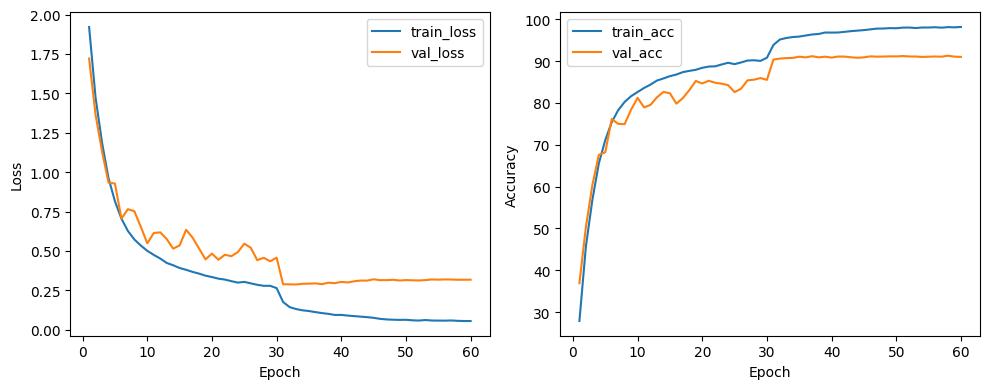

Best val acc - plain: 87.62  resnet: 91.3


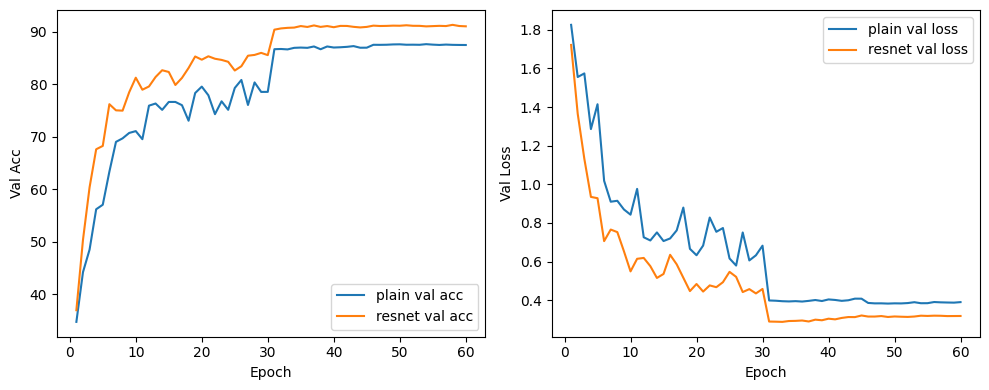

In [ ]:
# Colab/PyTorch notebook script
# Run in a GPU runtime. Tested with PyTorch 2.x APIs.
import os
import math
import time
import copy
import csv
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

# -------------------------
# Utilities
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)

def save_checkpoint(state, fname):
    torch.save(state, fname)

def plot_curves(history, outdir='results'):
    Path(outdir).mkdir(exist_ok=True, parents=True) # Added parents=True here
    # history: dict with keys 'train_loss','val_loss','train_acc','val_acc'
    epochs = range(1, len(history['train_loss'])+1)
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, history['train_loss'], label='train_loss')
    plt.plot(epochs, history['val_loss'], label='val_loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, history['train_acc'], label='train_acc')
    plt.plot(epochs, history['val_acc'], label='val_acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(outdir,'training_curves.png'))
    plt.show()

def write_csv_log(history, fname):
    keys = list(history.keys())
    with open(fname, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(keys)
        for i in range(len(history['train_loss'])):
            writer.writerow([history[k][i] for k in keys])

# -------------------------
# Models
# -------------------------
# PlainNet: simple stack of conv layers (builds similar depth as ResNet baseline)
class PlainNet(nn.Module):
    def __init__(self, n_blocks=3, num_classes=10):
        super().__init__()
        # For CIFAR-style layout: first conv then 3 groups of 2n conv layers
        # We'll implement small network similar to paper: num filters 16,32,64
        layers = []
        in_ch = 3
        out_chs = [16, 32, 64]
        for i, out_ch in enumerate(out_chs):
            num = 2 * n_blocks  # number of convs per stage
            for j in range(num):
                layers.append(nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False))
                layers.append(nn.BatchNorm2d(out_ch))
                layers.append(nn.ReLU(inplace=True))
                in_ch = out_ch
            if i < len(out_chs)-1:
                layers.append(nn.Conv2d(in_ch, in_ch, kernel_size=3, stride=2, padding=1, bias=False))  # downsample conv with stride 2
                layers.append(nn.BatchNorm2d(in_ch))
                layers.append(nn.ReLU(inplace=True))
        self.features = nn.Sequential(*layers)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(out_chs[-1], num_classes)
    def forward(self, x):
        x = self.features(x)
        x = self.pool(x).flatten(1)
        x = self.fc(x)
        return x

# Basic residual block (two 3x3 convs) - like paper's basic block
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = None
        if stride != 1 or in_planes != planes:
            # projection shortcut (1x1 conv) OR use identity with padding - paper uses identity+zero-pad for CIFAR,
            # but projection is fine and commonly used in modern ResNet impl.
            self.downsample = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )
    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

class ResNetCIFAR(nn.Module):
    def __init__(self, n_blocks=3, num_classes=10):
        super().__init__()
        self.in_planes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        # layers: 3 groups with filters 16,32,64
        self.layer1 = self._make_layer(16, blocks=2*n_blocks, stride=1)
        self.layer2 = self._make_layer(32, blocks=2*n_blocks, stride=2)
        self.layer3 = self._make_layer(64, blocks=2*n_blocks, stride=2)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(64, num_classes)
    def _make_layer(self, planes, blocks, stride):
        layers = []
        layers.append(BasicBlock(self.in_planes, planes, stride=stride))
        self.in_planes = planes
        for _ in range(1, blocks):
            layers.append(BasicBlock(self.in_planes, planes, stride=1))
        return nn.Sequential(*layers)
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.pool(out).flatten(1)
        out = self.fc(out)
        return out

# -------------------------
# Datasets and transforms (paper-style CIFAR-10 augmentation)
# -------------------------
def get_dataloaders(batch_size=128, datadir='./data'):
    transform_train = transforms.Compose([
        transforms.Pad(4),
        transforms.RandomCrop(32),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914,0.4822,0.4465),(0.247,0.243,0.261))
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914,0.4822,0.4465),(0.247,0.243,0.261))
    ])
    trainset = datasets.CIFAR10(root=datadir, train=True, download=True, transform=transform_train)
    testset = datasets.CIFAR10(root=datadir, train=False, download=True, transform=transform_test)
    # create a small validation split from train if desired; paper uses train/test splits directly. We'll use train/val (45k/5k)
    # but for simpler reproduction we use entire train as train and test as test (paper used train/val for scheduling).
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    testloader = DataLoader(testset, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)
    return trainloader, testloader

# -------------------------
# Training and evaluation
# -------------------------
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += imgs.size(0)
    return running_loss/total, 100.0*correct/total

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss=0.0
    correct=0
    total=0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * imgs.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += imgs.size(0)
    return running_loss/total, 100.0*correct/total

# -------------------------
# Experiment runner
# -------------------------
def run_experiment(model_name='resnet', n_blocks=3, epochs=60, batch_size=128, lr=0.1, outdir='results'):
    Path(outdir).mkdir(exist_ok=True, parents=True) # Added parents=True here
    trainloader, testloader = get_dataloaders(batch_size=batch_size)
    if model_name == 'resnet':
        model = ResNetCIFAR(n_blocks=n_blocks, num_classes=10).to(device)
    else:
        model = PlainNet(n_blocks=n_blocks, num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
    # LR schedule similar to paper: drop by 10 at some epochs (we'll drop at epochs 30 and 45 for 60-epoch run)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(epochs*0.5), int(epochs*0.75)], gamma=0.1)

    history = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}
    best_val_acc = 0.0
    for epoch in range(1, epochs+1):
        t0 = time.time()
        train_loss, train_acc = train_one_epoch(model, trainloader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, testloader, criterion, device)
        scheduler.step()
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        t1 = time.time()
        print(f"Epoch {epoch}/{epochs} | Train loss {train_loss:.4f} acc {train_acc:.2f}% | Val loss {val_loss:.4f} acc {val_acc:.2f}% | time {t1-t0:.1f}s")
        # save checkpoint
        save_checkpoint({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc
        }, os.path.join(outdir, f'{model_name}_epoch{epoch}.pth'))
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            save_checkpoint({'model_state_dict':model.state_dict(),'val_acc':val_acc}, os.path.join(outdir, f'{model_name}_best.pth'))
    # Save logs and plot
    write_csv_log(history, os.path.join(outdir, f'{model_name}_history.csv'))
    plot_curves(history, outdir)
    return history, best_val_acc

# -------------------------
# Run both models
# -------------------------
if __name__ == '__main__':
    # choose n_blocks: n_blocks=3 -> depth 6n+2 = 20 (ResNet-20) like paper example.
    n_blocks = 3
    epochs = 60  # increase to 200 for stronger results
    # Run plain network
    print("Training plain network ...")
    plain_hist, plain_best = run_experiment(model_name='plain', n_blocks=n_blocks, epochs=epochs, batch_size=128, lr=0.1, outdir='results/plain')
    # Run resnet
    print("Training residual network ...")
    res_hist, res_best = run_experiment(model_name='resnet', n_blocks=n_blocks, epochs=epochs, batch_size=128, lr=0.1, outdir='results/resnet')
    print("Best val acc - plain:", plain_best, " resnet:", res_best)
    # Save a combined comparison plot
    plt.figure(figsize=(10,4))
    epochs_range = range(1, epochs+1)
    plt.subplot(1,2,1)
    plt.plot(epochs_range, plain_hist['val_acc'], label='plain val acc')
    plt.plot(epochs_range, res_hist['val_acc'], label='resnet val acc')
    plt.xlabel('Epoch'); plt.ylabel('Val Acc'); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs_range, plain_hist['val_loss'], label='plain val loss')
    plt.plot(epochs_range, res_hist['val_loss'], label='resnet val loss')
    plt.xlabel('Epoch'); plt.ylabel('Val Loss'); plt.legend()
    plt.tight_layout()
    plt.savefig('results/comparison.png')
    plt.show()